# How to implement a neural network (4/5) - vectorization of operations

## Vectorization of the backpropagation algorithm

This last part will illustrate how to [vectorize the backpropagation algorithm](#Vectorization-of-backpropagation) to run it on multidimensional datasets and parameters. We will also illustrate the practice of [gradient checking](#Gradient-checking) to verify that our gradient implementations are correct. The final network will be trained with [momentum](#Backpropagation-updates-with-momentum) which is an adaptation of the gradient descent algorithm by adding a momentum parameter.

These concepts will be illustrated based on a toy example of a neural network that takes 2-dimensional input samples, projects them onto a 3-dimensional hidden layer, and classifies them with a 2-dimensional [softmax](http://en.wikipedia.org/wiki/Softmax_function) output classfier, this softmax function is explained in detail in [this tutorial]({% post_url /blog/cross_entropy/2015-06-11-cross-entropy-softmax %}). This toy network can be represented graphically as:


![Image of the neural network](/images/neural_net_implementation/SimpleANN04.png)

This is the fourth part of a 5-part tutorial on how to implement neural networks from scratch in Python:
- [Part 1: Gradient descent]({% post_url /blog/neural_net_implementation/2015-06-12-neural-network-implementation-part01 %})
- [Part 2: Classification]({% post_url /blog/neural_net_implementation/2015-06-13-neural-network-implementation-part02 %})
- [Part 3: Hidden layers trained by backpropagation]({% post_url /blog/neural_net_implementation/2015-06-14-neural-network-implementation-part03 %})
- [Part 4: Vectorization of the operations (this)]({% post_url /blog/neural_net_implementation/2015-06-15-neural-network-implementation-part04 %})
- [Part 5: Generalization to multiple layers]({% post_url /blog/neural_net_implementation/2015-06-16-neural-network-implementation-part05 %})

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np  # Matrix and vector computation package
import sklearn
import sklearn.datasets # To generate the dataset
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)
#

## Define the dataset 

In this example the target classes $t$ corresponding to the inputs $x$ will be generated from 2 class distributions: red stars ($t=0$) and blue circles ($t=1$). The red stars follow a circular distribution that surrounds the distribution of the blue circles.

This results in a 2D dataset that is not linearly separable. The model from [part 2]({% post_url /blog/neural_net_implementation/2015-06-13-neural-network-implementation-part02 %}) won't be able to classify both classes correctly since it can learn only linear separators. By adding a hidden layer, the model will be able to train a non-linear separator.

The $N$ input samples with $2$ variables each are given as a $N \times 2$ matrix $X$:

$$X =
\begin{bmatrix} 
x_{11} & x_{12} \\
\vdots & \vdots \\
x_{N1} & x_{N2}
\end{bmatrix}$$

Where $x_{ij}$ is the value of the $j$-th variable of the $i$-th input sample.

Since the softmax output function is used the targets for each input sample are given as a $N \times 2$ matrix $T$:

$$T = \begin{bmatrix} 
t_{11} & t_{12}\\
\vdots & \vdots \\
t_{N1} & t_{N2} 
\end{bmatrix}$$

Where $t_{ij} = 1$ if and only if the $i$-th input sample belongs to class $j$. So blue circles are labelled T = [0 1] and red stars are labelled T = [1 0].

In [2]:
# Generate the dataset
X, t = sklearn.datasets.make_circles(
    n_samples=100, shuffle=False, factor=0.3, noise=0.1)
T = np.zeros((100, 2)) # Define target matrix
T[t==1, 1] = 1
T[t==0, 0] = 1
# Separate the red and blue samples for plotting
x_red = X[t==0]
x_blue = X[t==1]

print('shape of X: {}'.format(X.shape))
print('shape of T: {}'.format(T.shape))
#

shape of X: (100, 2)
shape of T: (100, 2)


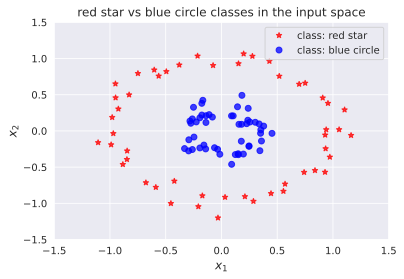

In [3]:
# Plot both classes on the x1, x2 plane
plt.figure(figsize=(6, 4))
plt.plot(x_red[:,0], x_red[:,1], 'r*', 
         label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', 
         label='class: blue circle', alpha=0.75)
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red star vs blue circle classes in the input space')
plt.show()
#

## Vectorization of backpropagation

### 1. Vectorization of the forward step

#### Compute activations of hidden layer
The 2-dimensional inputs $X$ are projected onto the 3 dimensions of the hidden layer $H$ by the weight matrix $W_h$ ($w_{hij}$ is the weight of the connection between input variable $i$ and hidden neuron activation $j$) and bias vector $\mathbf{b}_h$ :

$$
\begin{align}
W_h =
\begin{bmatrix} 
w_{h11} & w_{h12} & w_{h13} \\
w_{h21} & w_{h22} & w_{h23}
\end{bmatrix}
&& \mathbf{b}_h = 
\begin{bmatrix} 
b_{h1} & b_{h2} & b_{h3}
\end{bmatrix}
\end{align}
$$

following computation: 

$$
H = \sigma(X \cdot W_h + \mathbf{b}_h) = \frac{1}{1+e^{-(X \cdot W_h + \mathbf{b}_h)}} = \begin{bmatrix} 
h_{11} & h_{12} & h_{13} \\
\vdots & \vdots & \vdots \\
h_{N1} & h_{N2} & h_{N3}
\end{bmatrix}
$$

With $\sigma$ the logistic function, and with $H$ resulting in a $N \times 3$ matrix.

This computation flow is illustrated by the figure below. Each input $x_{ij}$ is multiplied with the weight parameters from the corresponding column $w_{hj1}, w_{hj2}, w_{hj3}$. The multiplication results for each row $k$ ($x_{ij} \cdot w_{hjk}$) are summed to form the $z_{ik}$, after which these are transformed by the logistic function $\sigma$ to the $h_{ik}$. Note that the bias $B_h$ can be incorporated in $W_h$ by adding a new variable to each input $\mathbf{x}_i$ that is always $+1$.

![Image of the hidden layer computation](/images/neural_net_implementation/ANN_layer_projection.png)

$\mathbf{b}_h$ and $W_h$ are represented in the code below by `bh` and `Wh` respectively. The hidden layer activations are computed by the `hidden_activations(X, Wh, bh)` method.

#### Compute activations of output 

To compute the output activations the hidden layer activations can be projected onto the 2-dimensional output layer. This is done by the $3 \times 2$ weight matrix $W_o$ ($w_{oij}$ is the weight of the connection between hidden layer neuron $i$ and output activation $j$) and $2 \times 1$ bias vector $\mathbf{b}_o$ :

$$\begin{align}
W_o =
\begin{bmatrix} 
w_{o11} & w_{o12} \\
w_{o21} & w_{o22} \\
w_{o31} & w_{o32}
\end{bmatrix}
&& \mathbf{b}_o = 
\begin{bmatrix} 
b_{o1} & b_{o2}
\end{bmatrix}
\end{align}$$

following computation: 

$$Y = \varsigma(H \cdot W_o + \mathbf{b}_o)
= \frac{e^{Z_o}}{\sum_{d=1}^C e^{\mathbf{z}_{od}}}
= \frac{e^{H \cdot W_o + \mathbf{b}_o}}{\sum_{d=1}^C e^{H \cdot \mathbf{w}_{od} + b_{od}}}
= \begin{bmatrix} 
y_{11} & y_{12}\\
\vdots & \vdots \\
y_{n1} & y_{n2} 
\end{bmatrix}$$

With $\varsigma$ the softmax function, $Y$ resulting in a $n \times 2$ matrix, $\mathbf{z}_{od}$ the $d$-th column of the $Z_o$ matrix, $\mathbf{w}_{od}$ the $d$-th column of the $W_o$ matrix, and $b_{od}$ the $d$-th element of the $b_o$ vector.

$\mathbf{b}_o$ and $W_o$ are represented in the code below by `bo` and `Wo` respectively. The hidden layer activations are computed by the `output_activations(H, Wo, bo)` method.

In [4]:
def logistic(z):
    """Logistic function."""
    return 1. / (1. + np.exp(-z))


def softmax(z):
    """Softmax function"""
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)


def hidden_activations(X, Wh, bh):
    """Compute the hidden activations h"""
    return logistic((X @ Wh) + bh)


def output_activations(H, Wo, bo):
    """Compute the output y"""
    return softmax((H @ Wo) + bo)


def nn(X, Wh, bh, Wo, bo):
    """Neural network as function."""
    return output_activations(hidden_activations(X, Wh, bh), Wo, bo)


def nn_predict(X, Wh, bh, Wo, bo):
    """Neural network prediction function that only returns
    1 or 0 depending on the predicted class"""
    return np.around(nn(X, Wh, bh, Wo, bo))

### 2. Vectorization of the backward step

#### Vectorization of the output layer backward step

##### Compute the error at the output

The output layer is a [softmax](http://en.wikipedia.org/wiki/Softmax_function) layer with corresponding [cross-entropy](http://en.wikipedia.org/wiki/Cross_entropy) loss function, which are described in detail in [this post]({% post_url /blog/cross_entropy/2015-06-11-cross-entropy-softmax %}). The loss function $\xi$ for $N$ samples and $C$ classes used in this model is defined as:

$$
\xi(T,Y) = \sum_{i=1}^n \xi(\mathbf{t}_i,\mathbf{y}_i) = - \sum_{i=1}^n \sum_{i=c}^{C} t_{ic} \cdot log( y_{ic})
$$

The error gradient $\delta_{o}$ of this loss function at the softmax output layer is simply:

$$
\delta_{o} = \frac{\partial \xi}{\partial Z_o} = Y - T
$$

With $Z_o$ a $n \times 2$ matrix of inputs to the softmax layer ($Z_o = H \cdot W_o + \mathbf{b}_o$), and $T$ a $n \times 2$ target matrix that corresponds to $Y$. Note that $\delta_{o}$ also results in a $n \times 2$ matrix.

$\delta_{o}$ will be defined in the code as `Eo` and will be computed by the `error_output(Y, T)` method defined below.

##### Update the output layer weights
At the output the gradient $\delta_{\mathbf{w}_{oj}}$ over all $N$ samples is computed by ${\partial \xi}/{\partial \mathbf{w}_{oj}}$:

$$
\frac{\partial \xi}{\partial \mathbf{w}_{oj}} = 
\frac{\partial \xi}{\partial Y} \frac{\partial Y}{\partial Z_{o}} \frac{\partial Z_{o}}{\partial \mathbf{w}_{oj}} = 
\frac{\partial \xi}{\partial Z_o} \frac{\partial Z_{o}}{\partial w_{oji}} =
\sum_{i=1}^N h_{ij} (\mathbf{y}_i - \mathbf{t}_i) = 
\sum_{i=1}^N h_{ij} \delta_{oi}
$$

With $\mathbf{w}_{oj}$ the $j$-th row of $W_o$ and thus a $1 \times 2$ vector. This formula can be written out as matrix operations with the parameters of the output layer:

$$
\frac{\partial \xi}{\partial W_o} = H^T \cdot (Y-T) = H^T \cdot \delta_{o}
$$

The resulting gradient is a $3 \times 2$ [Jacobian matrix](http://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant):

$$
J_{W_o} = \frac{\partial \xi}{\partial W_o} =
\begin{bmatrix} 
\frac{\partial \xi}{\partial w_{o11}} & \frac{\partial \xi}{\partial w_{o12}} \\
\frac{\partial \xi}{\partial w_{o21}} & \frac{\partial \xi}{\partial w_{o22}} \\
\frac{\partial \xi}{\partial w_{o31}} & \frac{\partial \xi}{\partial w_{o32}}
\end{bmatrix}
$$

$J_{W_o}$ will be defined in the code as `JWo` and will be computed by the `gradient_weight_out(H, Eo)` method defined below.


##### Update the output layer bias
The bias $\mathbf{b}_o$ can be updated in the same manner. The formula to compute the gradient ${\partial \xi}/{\partial \mathbf{b}_{o}}$ for batch processing over all $N$ samples is:

$$
\frac{\partial \xi}{\partial \mathbf{b}_{o}} 
= \frac{\partial \xi}{\partial Y} \frac{\partial Y}{\partial Z_{o}}  \frac{\partial Z_{o}}{\partial \mathbf{b}_{o}}
= \sum_{i=1}^N 1 \cdot (\mathbf{y}_i - \mathbf{t}_i) 
= \sum_{i=1}^N \delta_{oi}
$$

The resulting gradient is a $1 \times 2$ Jacobian matrix:

$$
J_{b_o} = \frac{\partial \xi}{\partial \mathbf{b}_o} =
\begin{bmatrix} 
\frac{\partial \xi}{\partial b_{o1}} & \frac{\partial \xi}{\partial b_{o2}}
\end{bmatrix}
$$

$J_{b_o}$ will be defined in the code as `Jbo` and will be computed by the `gradient_bias_out(Eo)` method defined below.

In [5]:
def loss(Y, T):
    """Loss function"""
    return - (T * np.log(Y)).sum()


def error_output(Y, T):
    """Error function at the output"""
    return Y - T


def gradient_weight_out(H, Eo):
    """Gradients for the weight parameters at the output layer"""
    return  H.T @ Eo


def gradient_bias_out(Eo):
    """Gradients for the bias parameters at the output layer"""
    return  np.sum(Eo, axis=0, keepdims=True)

#### Vectorization of the hidden layer backward step

##### Compute the error at the hidden layer

The error gradient $\delta_{h}$ of the loss function at the hidden layer is defined as:

$$\delta_{h} 
= \frac{\partial \xi}{\partial Z_h} 
= \frac{\partial \xi}{\partial H} \frac{\partial H}{\partial Z_h} 
= \frac{\partial \xi}{\partial Z_o} \frac{\partial Z_o}{\partial H} \frac{\partial H}{\partial Z_h}
$$

With $Z_h$ a $n \times 3$ matrix of inputs to the logistic functions in the hidden neurons ($Z_h = X \cdot W_h + \mathbf{b}_h$). Note that $\delta_{h}$ will also result in a $N \times 3$ matrix.

Lets first derive the error gradient $\delta_{hij}$ for one sample $i$ at hidden neuron $j$. The gradients that backpropagate from the previous layer via the weighted connections are summed for each origin $h_{ij}$. 

$$
\delta_{hij} 
= \frac{\partial \xi}{\partial z_{hij}} 
= \frac{\partial \xi}{\partial \mathbf{z}_{oi}} \frac{\partial \mathbf{z}_{oi}}{\partial h_{ij}} \frac{\partial h_{ij}}{\partial z_{hij}} 
= h_{ij} (1-h_{ij}) \sum_{k=1}^2 w_{ojk} (y_{ik}-t_{ik})
= h_{ij} (1-h_{ij}) [\delta_{oi} \cdot \mathbf{w}_{oj}^T]
$$

Where $\mathbf{w}_{oj}$ is the $j$-th row of $W_o$, and thus a $1 \times 2$ vector and $\delta_{oi}$ is a $1 \times 2$ vector. The full $N \times 3$ error matrix $\delta_{h}$ can thus be calculated as:

$$
\delta_{h} = \frac{\partial \xi}{\partial Z_h} = H \circ (1 - H) \circ [\delta_{o} \cdot W_o^T]
$$

With $\circ$ the [elementwise product](http://en.wikipedia.org/wiki/Hadamard_product_%28matrices%29). 

$\delta_{h}$ will be defined in the code as `Eh` and will be computed by the `error_hidden(H, Wo, Eo)` method defined below.


##### Update the hidden layer weights
At the hidden layer the gradient ${\partial \xi}/{\partial \mathbf{w}_{hj}}$ over all $N$ samples can be computed by:

$$
\frac{\partial \xi}{\partial \mathbf{w}_{hj}} 
= \frac{\partial \xi}{\partial H} \frac{\partial H}{\partial Z_{h}} \frac{\partial Z_{h}}{\partial \mathbf{w}_{hj}} 
= \frac{\partial \xi}{\partial Z_h} \frac{\partial Z_{h}}{\partial \mathbf{w}_{hj}}
= \sum_{i=1}^N x_{ij} \delta_{hi}
$$

With $\mathbf{w}_{hj}$ the $j$-th row of $W_h$ and thus a $1 \times 3$ vector.  We can write this formula out as matrix operations with the parameters of the hidden layer:

$$\frac{\partial \xi}{\partial W_h} = X^T \cdot \delta_{h}$$

The resulting gradient is a $2 \times 3$ [Jacobian matrix](http://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant):

$$
J_{W_h} = \frac{\partial \xi}{\partial W_{h}} =
\begin{bmatrix} 
\frac{\partial \xi}{\partial w_{h11}} & \frac{\partial \xi}{\partial w_{h12}} & \frac{\partial \xi}{\partial w_{h13}} \\
\frac{\partial \xi}{\partial w_{h21}} & \frac{\partial \xi}{\partial w_{h22}} & \frac{\partial \xi}{\partial w_{h23}} \\
\end{bmatrix}
$$

$J_{W_h}$ will be defined in the code as `JWh` and will be computed by the `gradient_weight_hidden(X, Eh)` method defined below.

##### Update the hidden layer bias
The bias $\mathbf{b}_h$ can be updated in the same manner. The formula to compute the gradient ${\partial \xi}/{\partial \mathbf{b}_{h}}$ for batch processing over all $N$ samples is:

$$
\frac{\partial \xi}{\partial \mathbf{b}_{h}} 
= \frac{\partial \xi}{\partial H} \frac{\partial H}{\partial Z_{h}} \frac{\partial Z_{h}}{\partial \mathbf{b}_{h}}
= \sum_{j=1}^N \delta_{hj}
$$

The resulting gradient is a $1 \times 3$ Jacobian matrix:

$$
J_{b_h} = \frac{\partial \xi}{\partial \mathbf{b}_{h}} =
\begin{bmatrix} 
\frac{\partial \xi}{\partial b_{h1}} & \frac{\partial \xi}{\partial b_{h2}} & \frac{\partial \xi}{\partial b_{h3}}
\end{bmatrix}
$$

$J_{b_h}$ will be defined in the code as `Jbh` and will be computed by the `gradient_bias_hidden(Eh)` method defined below.

In [6]:
def error_hidden(H, Wo, Eo):
    """Error at the hidden layer.
    H * (1-H) * (E . Wo^T)"""
    return np.multiply(np.multiply(H,(1 - H)), (Eo @ Wo.T))


def gradient_weight_hidden(X, Eh):
    """Gradient for the weight parameters at the hidden layer"""
    return X.T @ Eh


def gradient_bias_hidden(Eh):
    """Gradient for the bias parameters at the output layer"""
    return  np.sum(Eh, axis=0, keepdims=True)

## Gradient checking

Programming the computation of the backpropagation gradient is prone to bugs. This is why it is recommended to [check the gradients](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization) of your models. Gradient checking is done by computing the [numerical gradient](http://en.wikipedia.org/wiki/Numerical_differentiation) of each parameter, and compare this value to the gradient found by backpropagation.

The numerical gradient ${\partial \xi}/{\partial \theta_i}$ for a parameter $\theta_i$ can be computed by:

$$\frac{\partial \xi}{\partial \theta_i}
= \frac{f(X, \theta_1, \cdots, \theta_i+\epsilon, \cdots, \theta_m) - f(X, \theta_1, \cdots, \theta_i-\epsilon, \cdots, \theta_m)}{2\epsilon}$$

Where $f$ if the neural network function that takes the input $X$ and all parameters $\theta$, and $\epsilon$ is the small change that is used to peturbate the parameter $\theta_i$. 

The numerical gradient for each parameter should be close to the backpropagation gradient for that parameter.

In [7]:
# Run Gradient checking

# Initialize weights and biases
init_var = 1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var

# Compute the gradients by backpropagation
# Compute the activations of the layers
H = hidden_activations(X, Wh, bh)
Y = output_activations(H, Wo, bo)
# Compute the gradients of the output layer
Eo = error_output(Y, T)
JWo = gradient_weight_out(H, Eo)
Jbo = gradient_bias_out(Eo)
# Compute the gradients of the hidden layer
Eh = error_hidden(H, Wo, Eo)
JWh = gradient_weight_hidden(X, Eh)
Jbh = gradient_bias_hidden(Eh)

# Combine all parameter matrices in a list
params = [Wh, bh, Wo, bo]
# Combine all parameter gradients in a list
grad_params = [JWh, Jbh, JWo, Jbo]

# Set the small change to compute the numerical gradient
eps = 0.0001

# Check each parameter matrix
for p_idx in range(len(params)):
    # Check each parameter in each parameter matrix
    for row in range(params[p_idx].shape[0]):
        for col in range(params[p_idx].shape[1]):
            # Copy the parameter matrix and change the current 
            #  parameter slightly
            p_matrix_min = params[p_idx].copy()
            p_matrix_min[row,col] -= eps
            p_matrix_plus = params[p_idx].copy()
            p_matrix_plus[row,col] += eps
            # Copy the parameter list, and change the updated 
            #  parameter matrix
            params_min = params[:]
            params_min[p_idx] = p_matrix_min
            params_plus = params[:]
            params_plus[p_idx] =  p_matrix_plus
            # Compute the numerical gradient
            grad_num = (
                loss(nn(X, *params_plus), T)-loss(nn(X, *params_min), T)
            ) / (2 * eps)
            # Raise error if the numerical grade is not close to the 
            #  backprop gradient
            if not np.isclose(grad_num, grad_params[p_idx][row,col]):
                raise ValueError((
                    f'Numerical gradient of {grad_num:.6f} '
                    'is not close to the backpropagation '
                    f'gradient of {grad_params[p_idx][row,col]:.6f}!'))
print('No gradient errors found')
#

No gradient errors found


### Backpropagation updates with momentum

In the previous examples we used simple [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) to optimize the parameters with respect to the loss function (which was [convex](http://en.wikipedia.org/wiki/Convex_function) in the [first]({% post_url /blog/neural_net_implementation/2015-06-12-neural-network-implementation-part01 %}) and [second]({% post_url /blog/neural_net_implementation/2015-06-13-neural-network-implementation-part02 %}) example). Multilayer neural networks with non-linear activation functions and many parameters are highly unlikely to have convex loss functions. Simple  gradient descent is not the best method to find a global minimum of a non-convex loss function since it is a [local optimization](http://en.wikipedia.org/wiki/Local_search_%28optimization%29) method that tends to converge to a [local minimum](http://en.wikipedia.org/wiki/Local_optimum).

To solve this issue this example uses a variant of gradient decent called momentum. The method of momentum can be visualized as a ball rolling down the surface of the loss function, this ball will gather [momentum](https://simple.wikipedia.org/wiki/Moment_(physics)) while rolling downhill, and will loose momentum when rolling uphill. This momentum update is formulated as:

$$
\begin{split}
M(i+1) & = \lambda M(i) - \mu \frac{\partial \xi}{\partial \theta(i)} \\
\theta(i+1) & = \theta(i) + M(i+1)
\end{split}
$$

Where $M(i)$ is the momentum of the parameters at iteration $i$, $\theta(i)$ is the location of the parameters at iteration $i$, ${\partial \xi}/{\partial \theta(i)}$ the gradient of the parameters with respect to the loss function at iteration $i$, $\lambda$ how much the momentum decreases due to 'friction' and $\mu$ the learning rate (how much the gradient affects the momentum). This formula can be visualised as in the following illustration:

![Momentum updates](/images/neural_net_implementation/Momentum.png)

The moments $M_{W_h}, M_{\mathbf{b}_h}, M_{W_o}, M_{\mathbf{b}_o},$ corresponding to the parameters $ W_h, \mathbf{b}_h, W_o, \mathbf{b}_o$ are represented in the code by `MWh`, `Mbh`, `MWo`, `Mbo`. And kept in a list `Ms`. They are updated by the `update_momentum(X, T, ls_of_params, Ms, momentum_term, learning_rate)` method. After updating the momentum the parameters are updated via the `update_params(ls_of_params, Ms)` method.

In [8]:
def backprop_gradients(X, T, Wh, bh, Wo, bo):
    """Update the network parameters over 1 iteration."""
    # Compute the output of the network
    # Compute the activations of the layers
    H = hidden_activations(X, Wh, bh)
    Y = output_activations(H, Wo, bo)
    # Compute the gradients of the output layer
    Eo = error_output(Y, T)
    JWo = gradient_weight_out(H, Eo)
    Jbo = gradient_bias_out(Eo)
    # Compute the gradients of the hidden layer
    Eh = error_hidden(H, Wo, Eo)
    JWh = gradient_weight_hidden(X, Eh)
    Jbh = gradient_bias_hidden(Eh)
    return [JWh, Jbh, JWo, Jbo]


def update_momentum(X, T, ls_of_params, Ms, momentum_term, 
                    learning_rate):
    """Update the momentum term."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Js = [JWh, Jbh, JWo, Jbo]
    Js = backprop_gradients(X, T, *ls_of_params)
    return [momentum_term * M - learning_rate * J 
            for M,J in zip(Ms, Js)]

def update_params(ls_of_params, Ms):
    """Update the parameters."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Ms = [MWh, Mbh, MWo, Mbo]
    return [P + M for P,M in zip(ls_of_params, Ms)]

Training the neural network model with this momentum method over $300$ iterations on the dataset $X$ and $T$ defined in the beginning results in the training convergence plotted in the figure below. This smooth convergence would almost never result from simple gradient descent. You can try it out yourself and implement gradient descent optimization for this model. You will notice that if you run your gradient descent a couple of times from different starting points that it will almost always converge to a sub-optimal solution. Note that momentum is less sensitive to the learning rate than gradient descent, but the learning rate hyperparameter still needs to be tuned separately. In this tutorial, this learning rate was tuned by experimentation.

In [9]:
# Run backpropagation
# Initialize weights and biases
init_var = 0.1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var
# Parameters are already initilized randomly with the gradient checking
# Set the learning rate
learning_rate = 0.02
momentum_term = 0.9

# Moments Ms = [MWh, Mbh, MWo, Mbo]
Ms = [np.zeros_like(M) for M in [Wh, bh, Wo, bo]]

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 300  # number of gradient descent updates
# learning rate update rule
lr_update = learning_rate / nb_of_iterations
# list of loss over the iterations
ls_loss = [loss(nn(X, Wh, bh, Wo, bo), T)]
for i in range(nb_of_iterations):
    # Update the moments and the parameters
    Ms = update_momentum(
        X, T, [Wh, bh, Wo, bo], Ms, momentum_term, learning_rate)
    Wh, bh, Wo, bo = update_params([Wh, bh, Wo, bo], Ms)
    ls_loss.append(loss(nn(X, Wh, bh, Wo, bo), T))

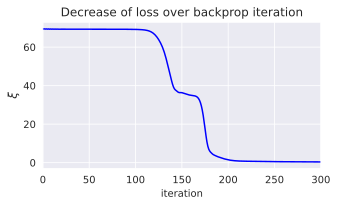

In [10]:
# Plot the loss over the iterations
fig = plt.figure(figsize=(5, 3))
plt.plot(ls_loss, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=12)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, 300)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

## Visualization of the trained classifier


The resulting decision boundary of running backpropagation with momentum on the example inputs $X$ and targets $T$ is shown in the figure below. The background color (blue, red) refers to the classification decision of the trained classifier at that position in the input space. Note that the classifier is able to surround the blue circles and that all examples are classified correctly by the trained classifier.

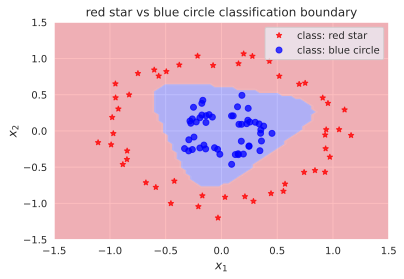

In [11]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 100
xs1 = np.linspace(-2, 2, num=nb_of_xs)
xs2 = np.linspace(-2, 2, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(
            np.asarray([xx[i,j], yy[i,j]]), Wh, bh, Wo, bo)
        classification_plane[i,j] = pred[0, 0]
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.25),
        colorConverter.to_rgba('r', alpha=0.25)])
plt.figure(figsize=(6, 4))
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 
         'r*', label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 
         'bo', label='class: blue circle', alpha=0.75)
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red star vs blue circle classification boundary')
plt.show()
#

## Transformation of the input domain

There are two reasons why the neural network is able to separate the non-linearly separable classes. First of all the non-linear logistic functions in the hidden layer can help to make non-linear transformations of the data. And second the hidden layer contains three dimensions. By projecting the 2-dimensional input data to 3 dimensions, the classes can become linearly separable in this 3-dimensional space. This projection in illustrated in the figure below that plots the transformations of the input samples upon this 3-dimensional hidden layer.

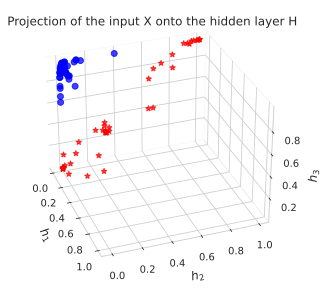

In [12]:
# Plot the projection of the input onto the hidden layer

# Define the projections of the blue and red classes
H_blue = hidden_activations(x_blue, Wh, bh)
H_red = hidden_activations(x_red, Wh, bh)
# Plot the error surface
fig = plt.figure(figsize=(6, 5))
with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.plot(
        np.ravel(H_blue[:,0]), np.ravel(H_blue[:,1]), np.ravel(H_blue[:,2]),
        'bo', label='class: blue circle', alpha=0.75)
    ax.plot(
        np.ravel(H_red[:,0]), np.ravel(H_red[:,1]), np.ravel(H_red[:,2]), 
        'r*', label='class: red star', alpha=0.75)
    ax.set_xlabel('$h_1$', fontsize=12)
    ax.set_ylabel('$h_2$', fontsize=12)
    ax.set_zlabel('$h_3$', fontsize=12)
    ax.view_init(elev=30, azim=-20)
    ax.set_title('Projection of the input X onto the hidden layer H', y=0.99)
plt.show()
#

This was the fourth part of a 5-part tutorial on how to implement neural networks from scratch in Python:
- [Part 1: Gradient descent]({% post_url /blog/neural_net_implementation/2015-06-12-neural-network-implementation-part01 %})
- [Part 2: Classification]({% post_url /blog/neural_net_implementation/2015-06-13-neural-network-implementation-part02 %})
- [Part 3: Hidden layers trained by backpropagation]({% post_url /blog/neural_net_implementation/2015-06-14-neural-network-implementation-part03 %})
- [Part 4: Vectorization of the operations (this)]({% post_url /blog/neural_net_implementation/2015-06-15-neural-network-implementation-part04 %})
- [Part 5: Generalization to multiple layers]({% post_url /blog/neural_net_implementation/2015-06-16-neural-network-implementation-part05 %})

In [13]:
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.23.1

numpy     : 1.20.2
sklearn   : 0.24.2
seaborn   : 0.11.1
matplotlib: 3.4.2



This post at <a rel="canonical" href="https://peterroelants.github.io/posts/neural-network-implementation-part04/">peterroelants.github.io</a> is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/neural_net_implementation/neural-network-implementation-part04.ipynb)